In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distanc

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
dataset_name = 'MMD-MA'
dataset_color = 'lime'
modality_names = ['Modality 1', 'Modality 2']
data_folder = '../data/UnionCom/MMD/'
data1 = np.loadtxt(data_folder + "s1_mapped1.txt")
data2 = np.loadtxt(data_folder + "s1_mapped2.txt")
type1 = np.loadtxt(data_folder + "s1_type1.txt")
type2 = np.loadtxt(data_folder + "s1_type2.txt")
type1 = type1.astype(int)
type2 = type2.astype(int)
type1 = np.array([f'Cell Type {i}' for i in type1])
type2 = np.array([f'Cell Type {i}' for i in type2])

# Labels
labels = [type1, type2]
features = [None, None]
feature_dict = {}

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:11.7152 alpha:0.1578
epoch:[1000/2000] err:10.2456 alpha:0.3746
epoch:[1500/2000] err:10.1076 alpha:0.4565
epoch:[2000/2000] err:10.0670 alpha:0.4759
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 300, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 300, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0016  Rec: 0.3933  CosSim: 0.1241  F: 0.0076
Epoch: 200 - KL: 0.0034  Rec: 0.3473  CosSim: 0.0355  F: 0.0052
Epoch: 300 - KL: 0.0075  Rec: 0.3297  CosSim: 0.0269  F: 0.0048
Epoch: 400 - KL: 0.0103  Rec: 0.3235  CosSim: 0.0218  F: 0.0036
Epoch: 500 - KL: 0.0132  Rec: 0.3178  CosSim: 0.0215  F: 0.0041
epoch:[500/10000]: loss:0.356655
Epoch: 600 - KL: 0.0166  Rec: 0.3223  CosSim: 0.0198  F: 0.0040
Epoch: 700 - KL: 0.0259  Rec: 0.3090  CosSim: 0.0227  F: 0.0040
Epoch: 800 - KL: 0.0413  Rec: 0.3011  CosSim: 0.0224  F: 0.0035
Epoch: 900 - KL: 0.0567  Rec: 0.3071  CosSim: 0.0234  F: 0.0038
Epoch: 1000 - KL: 0.0695  Rec: 0.3011  CosSim: 0.0245  F: 0.0036
epoch:[1000/10000]: loss:0.398702
Epoch: 1100 - KL: 0.0851  Rec: 0.2960  CosSim: 0.0291  F: 0.0033
Epoch: 1200 - KL: 0.0881  Rec: 0.2990  CosSim: 0.0330  F: 0.0036
Epoch: 1300 - KL: 0.1182  Rec: 0.2965  CosSim: 0.0366  F: 0.0035
Epoch: 1400 - KL: 0.1193  Rec: 0.3007  CosSim: 0.0397  F: 0.0039
Epoch: 1500 - KL: 0.1818  Rec: 0

In [9]:
# Integration (.75)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_75---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_75 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_75.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_75_data = jm_75.fit_transform(dataset=dataset, P=tq_priors)
    jm_75.save_model(model_str)
    np.save(match_str, jm_75.match_result, allow_pickle=True)
jm_75_data = jm_75.transform(dataset=dataset)
integrated_data.append(jm_75_data)
integrated_names.append( 'JAMIE (.75)')
colors.append('lawngreen')
shapes.append('^')

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:11.7152 alpha:0.1578
epoch:[1000/2000] err:10.2456 alpha:0.3746
epoch:[1500/2000] err:10.1076 alpha:0.4565
epoch:[2000/2000] err:10.0670 alpha:0.4759
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 300, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 300, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0014  Rec: 0.4181  CosSim: 0.1467  F: 0.0126
Epoch: 200 - KL: 0.0025  Rec: 0.3446  CosSim: 0.0288  F: 0.0064
Epoch: 300 - KL: 0.0038  Rec: 0.3204  CosSim: 0.0251  F: 0.0067
Epoch: 400 - KL: 0.0045  Rec: 0.3147  CosSim: 0.0186  F: 0.0052
Epoch: 500 - KL: 0.0039  Rec: 0.3140  CosSim: 0.0202  F: 0.0053
epoch:[500/10000]: loss:0.343372
Epoch: 600 - KL: 0.0071  Rec: 0.3157  CosSim: 0.0189  F: 0.0050
Epoch: 700 - KL: 0.0066  Rec: 0.3146  CosSim: 0.0178  F: 0.0051
Epoch: 800 - KL: 0.0082  Rec: 0.3120  CosSim: 0.0184  F: 0.0047
Epoch: 900 - KL: 0.0096  Rec: 0.3140  CosSim: 0.0198  F: 0.0045
Epoch: 1000 - KL: 0.0081  Rec: 0.3098  CosSim: 0.0204  F: 0.0042
epoch:[1000/10000]: loss:0.342424
Epoch: 1100 - KL: 0.0130  Rec: 0.2993  CosSim: 0.0189  F: 0.0045
Epoch: 1200 - KL: 0.0053  Rec: 0.3043  CosSim: 0.0248  F: 0.0047
Epoch: 1300 - KL: 0.0078  Rec: 0.2978  CosSim: 0.0256  F: 0.0040
Epoch: 1400 - KL: 0.0109  Rec: 0.2899  CosSim: 0.0226  F: 0.0041
Epoch: 1500 - KL: 0.0073  Rec: 0

In [10]:
# Integration (.5)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_50---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_50 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_50.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_50_data = jm_50.fit_transform(dataset=dataset, P=half_priors)
    jm_50.save_model(model_str)
    np.save(match_str, jm_50.match_result, allow_pickle=True)
jm_50_data = jm_50.transform(dataset=dataset)
integrated_data.append(jm_50_data)
integrated_names.append( 'JAMIE (.5)')
colors.append('midnightblue')
shapes.append('d')

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:11.7152 alpha:0.1578
epoch:[1000/2000] err:10.2456 alpha:0.3746
epoch:[1500/2000] err:10.1076 alpha:0.4565
epoch:[2000/2000] err:10.0670 alpha:0.4759
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 300, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 300, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0014  Rec: 0.4081  CosSim: 0.1777  F: 0.0220
Epoch: 200 - KL: 0.0020  Rec: 0.3350  CosSim: 0.0258  F: 0.0086
Epoch: 300 - KL: 0.0031  Rec: 0.3247  CosSim: 0.0209  F: 0.0066
Epoch: 400 - KL: 0.0031  Rec: 0.3147  CosSim: 0.0161  F: 0.0061
Epoch: 500 - KL: 0.0046  Rec: 0.3150  CosSim: 0.0155  F: 0.0057
epoch:[500/10000]: loss:0.340812
Epoch: 600 - KL: 0.0052  Rec: 0.3115  CosSim: 0.0166  F: 0.0061
Epoch: 700 - KL: 0.0061  Rec: 0.3156  CosSim: 0.0156  F: 0.0052
Epoch: 800 - KL: 0.0078  Rec: 0.2998  CosSim: 0.0187  F: 0.0051
Epoch: 900 - KL: 0.0058  Rec: 0.3103  CosSim: 0.0204  F: 0.0047
Epoch: 1000 - KL: 0.0080  Rec: 0.3042  CosSim: 0.0155  F: 0.0051
epoch:[1000/10000]: loss:0.332879
Epoch: 1100 - KL: 0.0106  Rec: 0.2988  CosSim: 0.0185  F: 0.0056
Epoch: 1200 - KL: 0.0115  Rec: 0.3012  CosSim: 0.0172  F: 0.0047
Epoch: 1300 - KL: 0.0058  Rec: 0.3082  CosSim: 0.0204  F: 0.0048
Epoch: 1400 - KL: 0.0097  Rec: 0.2914  CosSim: 0.0197  F: 0.0045
Epoch: 1500 - KL: 0.0048  Rec: 0

In [11]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (240, 2000)
Dataset 1: (240, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:10.1947 alpha:0.2296
epoch:[1000/2000] err:9.7660 alpha:0.3923
epoch:[1500/2000] err:10.4975 alpha:0.4947
epoch:[2000/2000] err:10.7172 alpha:0.6179
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 240, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 240, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0019  Rec: 0.4610  CosSim: 0.1939  F: 0.0171
Epoch: 200 - KL: 0.0037  Rec: 0.3797  CosSim: 0.0438  F: 0.0072
Epoch: 300 - KL: 0.0051  Rec: 0.3475  CosSim: 0.0329  F: 0.0069
Epoch: 400 - KL: 0.0091  Rec: 0.3522  CosSim: 0.0276  F: 0.0055
Epoch: 500 - KL: 0.0139  Rec: 0.3514  CosSim: 0.0254  F: 0.0058
epoch:[500/10000]: loss:0.396490
Epoch: 600 - KL: 0.0181  Rec: 0.3417  CosSim: 0.0263  F: 0.0049
Epoch: 700 - KL: 0.0277  Rec: 0.3329  CosSim: 0.0231  F: 0.0049
Epoch: 800 - KL: 0.0373  Rec: 0.3342  CosSim: 0.0239  F: 0.0052
Epoch: 900 - KL: 0.0430  Rec: 0.3327  CosSim: 0.0268  F: 0.0046
Epoch: 1000 - KL: 0.0589  Rec: 0.3226  CosSim: 0.0259  F: 0.0043
epoch:[1000/10000]: loss:0.411781
Epoch: 1100 - KL: 0.0858  Rec: 0.3217  CosSim: 0.0289  F: 0.0052
Epoch: 1200 - KL: 0.0902  Rec: 0.3142  CosSim: 0.0309  F: 0.0051
Epoch: 1300 - KL: 0.1672  Rec: 0.3162  CosSim: 0.0381  F: 0.0053
Epoch: 1400 - KL: 0.1486  Rec: 0.3072  CosSim: 0.0406  F: 0.0049
Epoch: 1500 - KL: 0.1308  Rec: 0

# Comparison Methods

In [12]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        # dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [13]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [14]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [15]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [16]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

2023-08-18 18:21:36.040811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-18 18:21:36.040866: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 18:21:36.040880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2023-08-18 18:21:36.041097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 18:21:36.046349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:

In [17]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:8.6272 alpha:0.5584
epoch:[200/2000] err:4.6881 alpha:0.3407
epoch:[300/2000] err:4.0472 alpha:0.3732
epoch:[400/2000] err:3.4251 alpha:0.4034
epoch:[500/2000] err:3.1781 alpha:0.4225
epoch:[600/2000] err:2.7653 alpha:0.4428
epoch:[700/2000] err:2.3510 alpha:0.4590
epoch:[800/2000] err:2.1487 alpha:0.4695
epoch:[900/2000] err:2.0433 alpha:0.4770
epoch:[1000/2000] err:1.9777 alpha:0.4831
epoch:[1100/2000] err:1.9333 alpha:0.4883
epoch:[1200/2000] err:1.9023 alpha:0.4929
epoch:[1300/2000] err:1.8805 alpha:0.4970
epoch:[1400/2000] err:1.8653 alpha:0.5005
epoch:[1500/2000] err:1.8550 alpha:0.5037
epoch:[1600/2000] err:1.8477 alpha:0.5066
epoch:[1700/2000] err:1.8422 alpha:0.5092
epoch:[1800/2000] err:1.8377 alpha:0.5115
epoch:[1900/2000] err:1.8339 alpha:0.5136
epoch:[2000/2000] err:1.

In [18]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [19]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'svg.fonttype': 'none',
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})
sns.set_palette('husl', len(np.unique(labels)))

In [20]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-LabelLegend.svg', bbox_inches=bbox, format='svg')

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.svg', bbox_inches=bbox, format='svg')

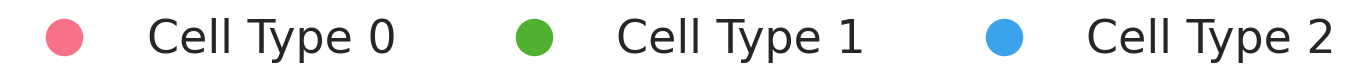

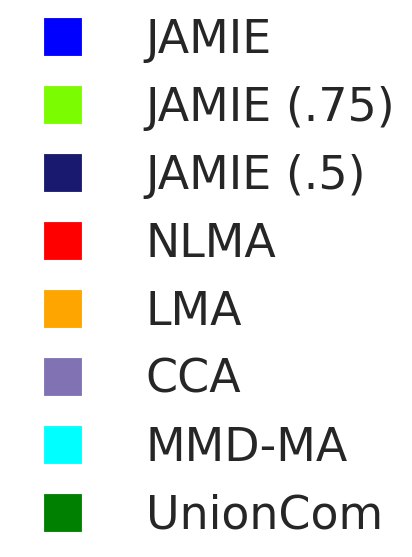

In [21]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

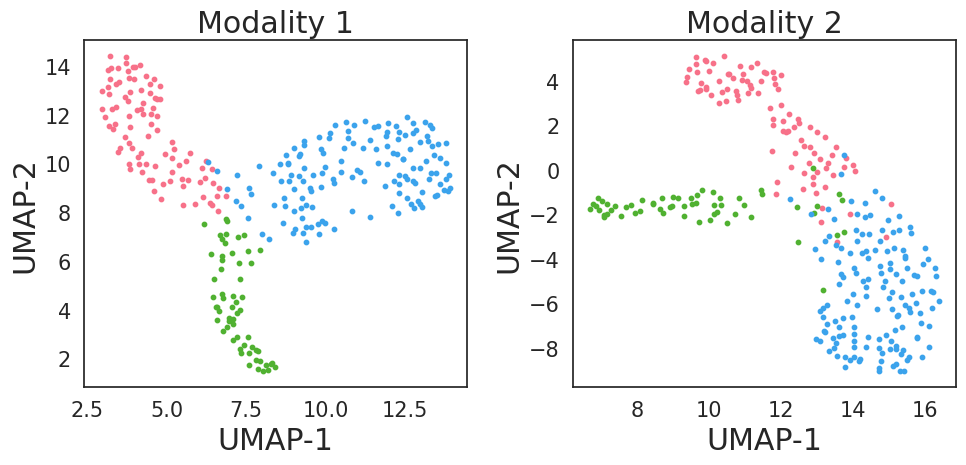

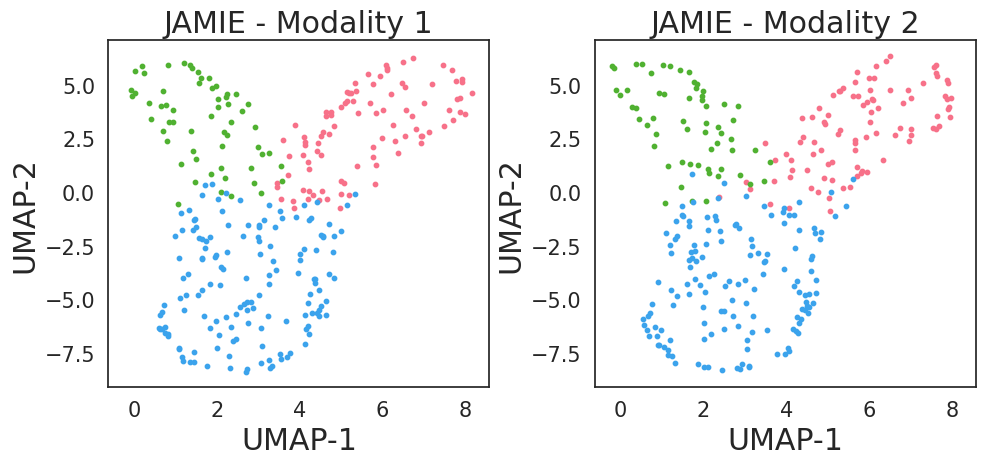

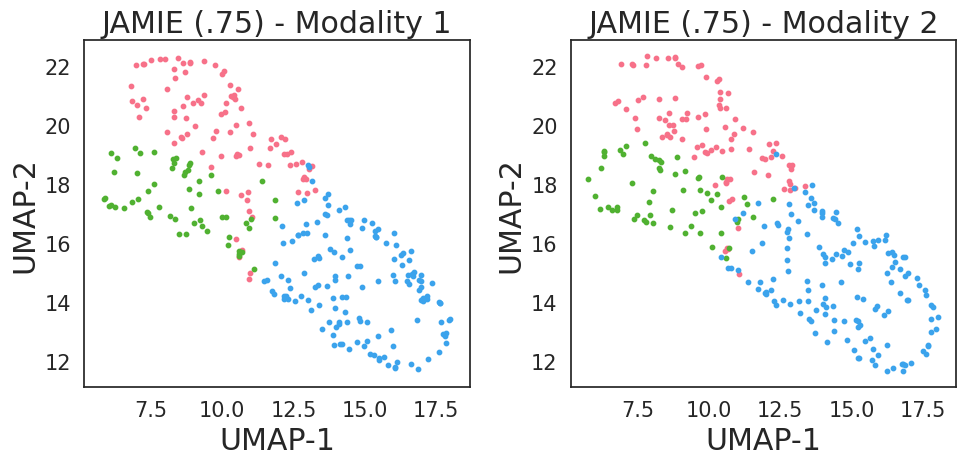

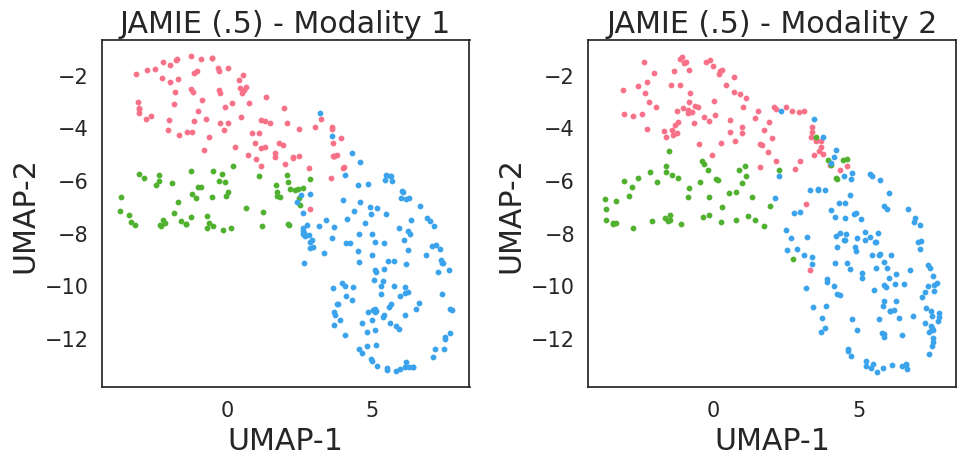

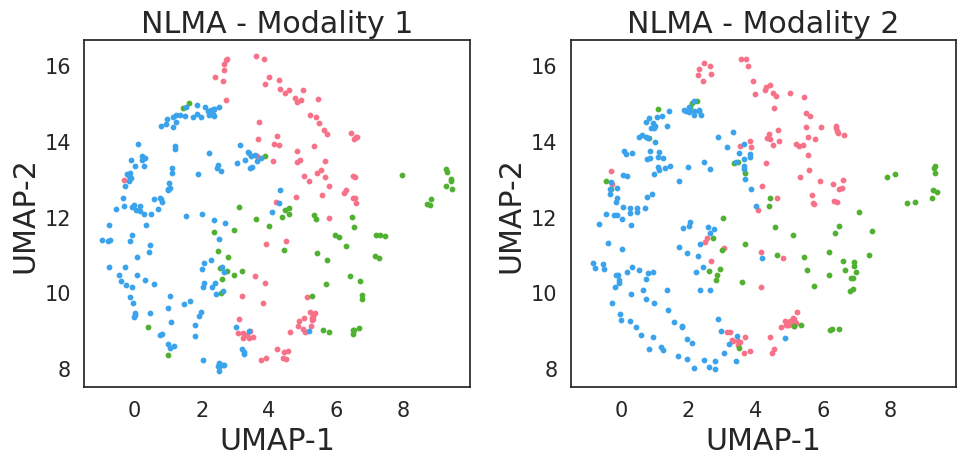

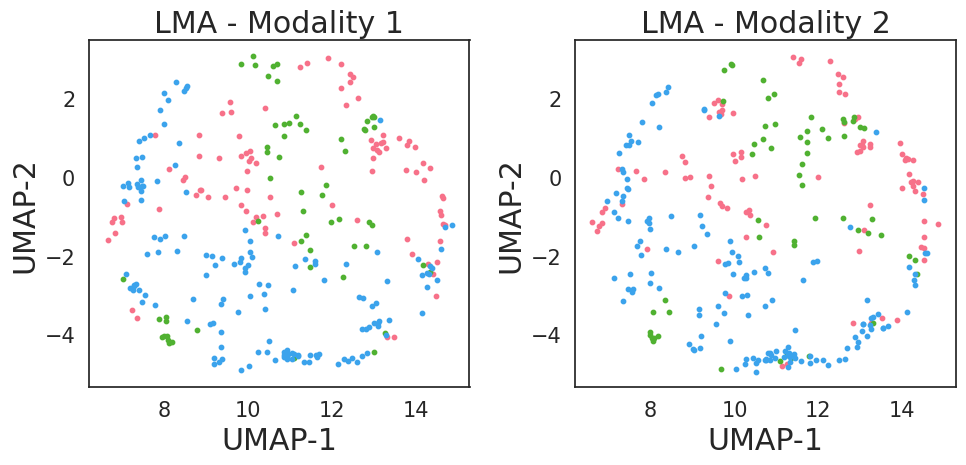

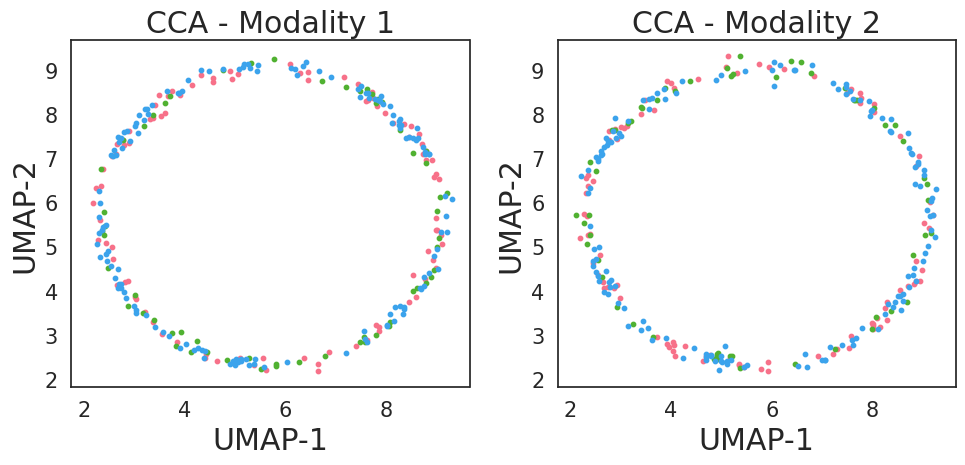

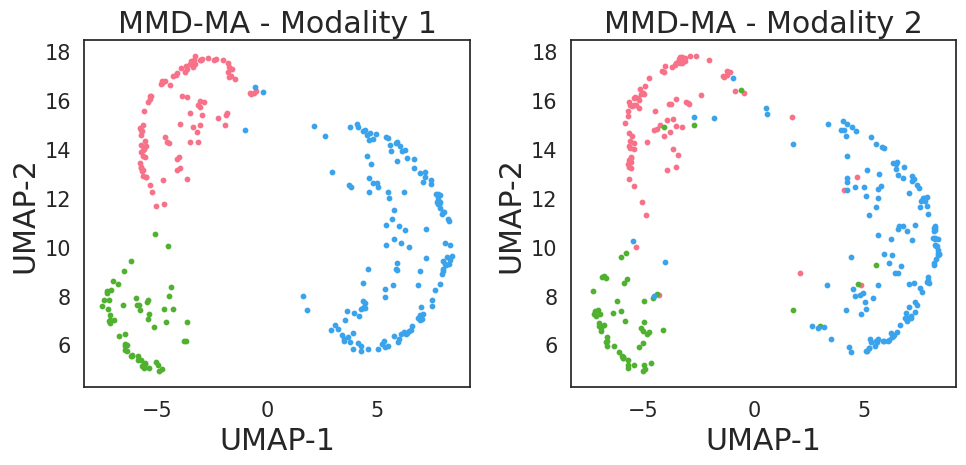

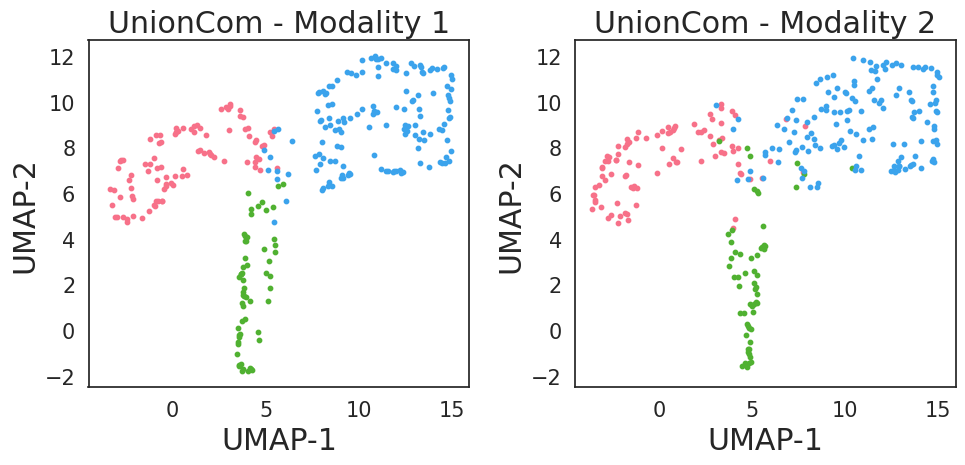

In [22]:
# Raw data
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Data.svg', format='svg', bbox_inches='tight')

# Integrated data
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.savefig(image_folder + dataset_name + f'-{n}.svg', format='svg', bbox_inches='tight')
    plt.show()

Algorithm     JAMIE      NLMA       LMA       CCA    MMD-MA  UnionCom
LTA        0.976667  0.970000  0.970000  0.306667  0.980000  0.956667
FOSCTTM    0.001383  0.000917  0.000922  0.986244  0.113161  0.079750
Algorithm     JAMIE  JAMIE (.75)  JAMIE (.5)      NLMA       LMA       CCA  \
LTA        0.976667     0.950000    0.950000  0.970000  0.970000  0.306667   
FOSCTTM    0.001383     0.034744    0.045144  0.000917  0.000922  0.986244   

Algorithm    MMD-MA  UnionCom  
LTA        0.980000  0.956667  
FOSCTTM    0.113161  0.079750  


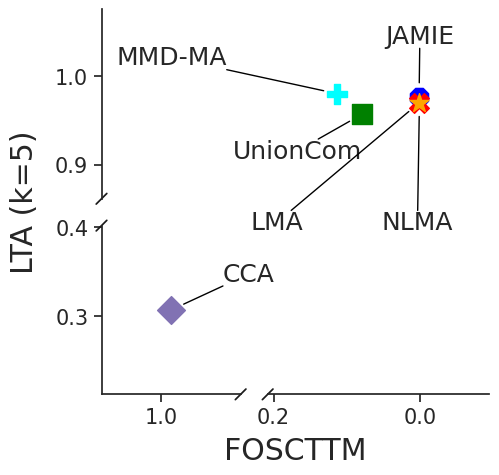

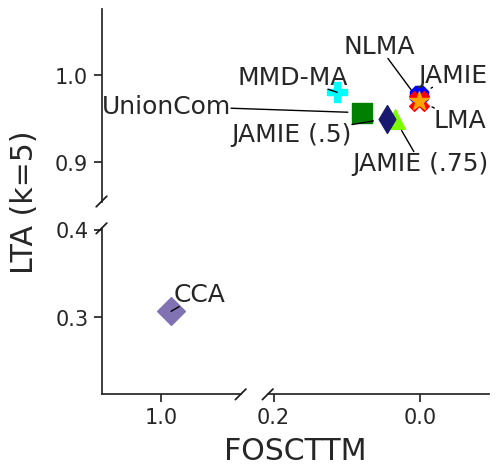

In [23]:
with_idx = [i for i in range(len(integrated_data)) if i not in (1, 2)]
# Without Partial
plt.figure(figsize=(5, 5))
idx = with_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx], expand_points=(2., 2.))
plt.savefig(image_folder + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Acc.svg', format='svg', bbox_inches='tight')

without_idx = list(range(len(integrated_data)))
# With Partial
plt.figure(figsize=(5, 5))
idx = without_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccPartial.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccPartial.svg', format='svg', bbox_inches='tight')

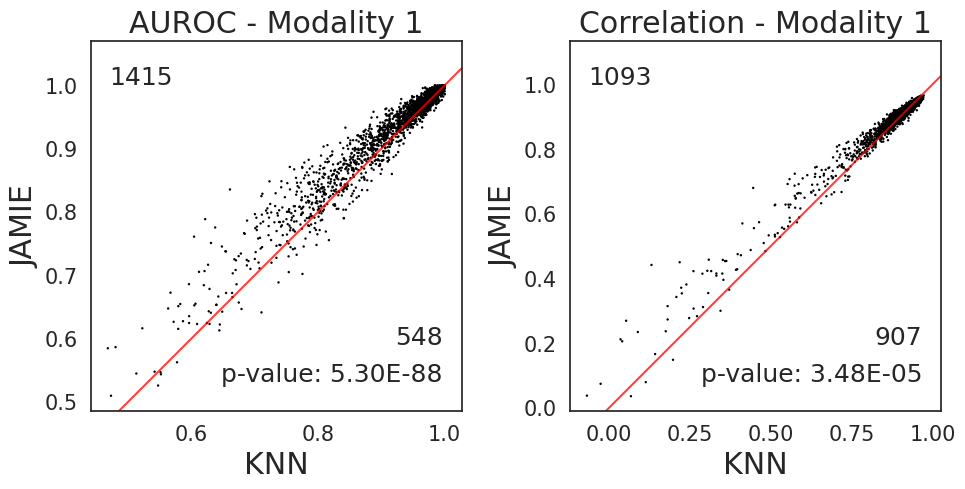

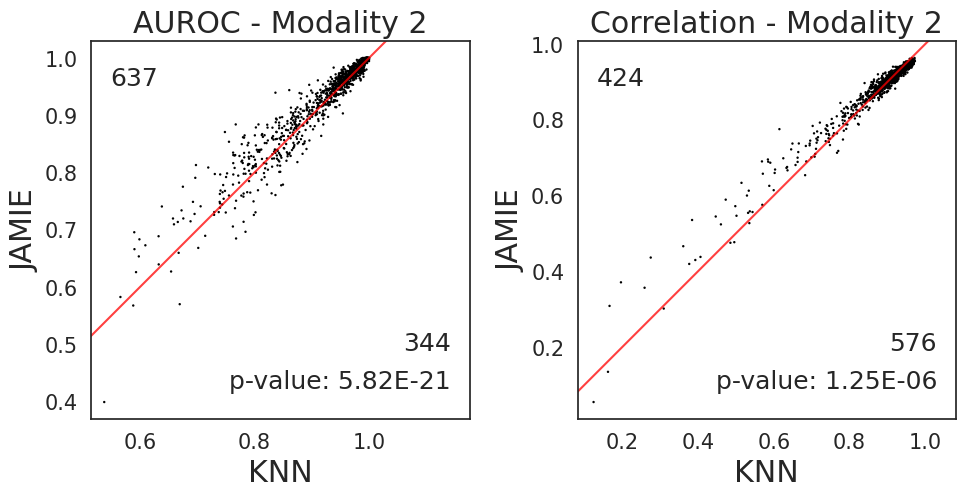

In [24]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2.svg', format='svg', bbox_inches='tight')

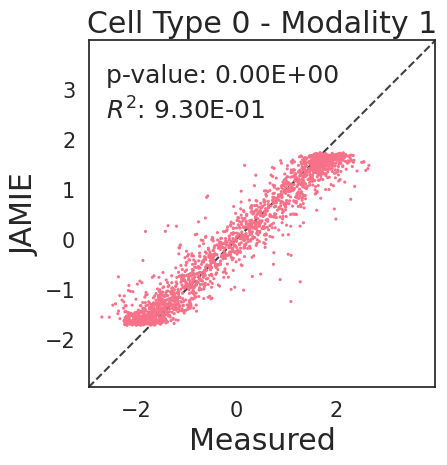

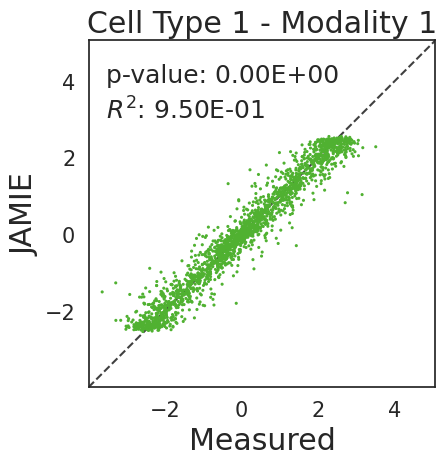

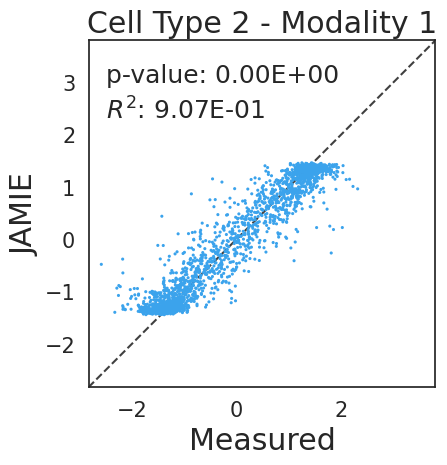

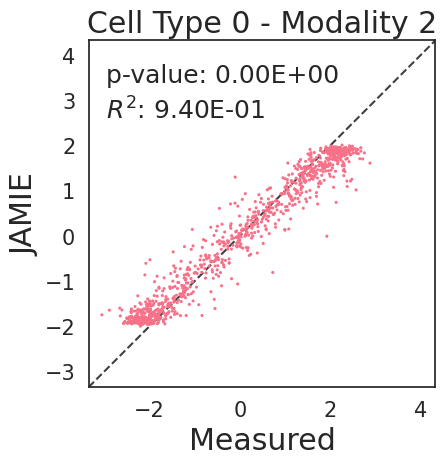

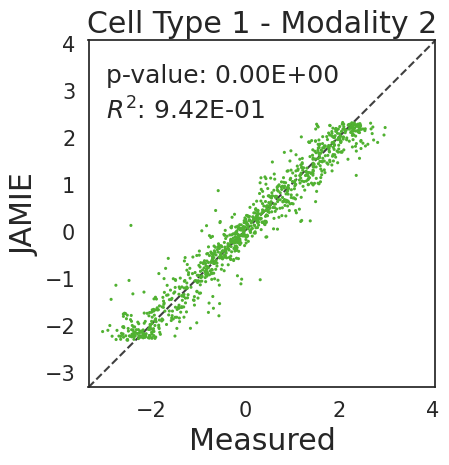

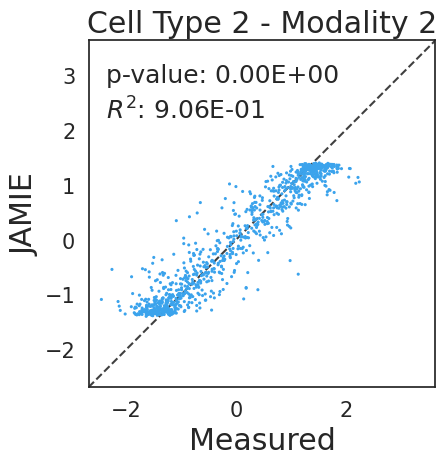

In [25]:
# Choose sample
for modality_idx in range(len(dataset)):
    for i, cell_type in enumerate(np.unique(labels[modality_idx][test_idx])):
        plt.figure(figsize=(5, 5))
        plot_sample(
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], dataset[modality_idx][test_idx]) if ct==cell_type]),
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], imputed_data[1][modality_idx]) if ct==cell_type]),
            imputed_names[1],
            modality_names[modality_idx],
            suptitle=cell_type,
            color=np.array(plt.rcParams['axes.prop_cycle'])[i]['color'])
        plt.tight_layout()
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.svg', format='svg', bbox_inches='tight')
        plt.show()

Feature 388: 0.2708626412707707
Feature 1004: 0.2755812648073922
Feature 970: 0.3075053863038875
Feature 546: 0.3327435667911696


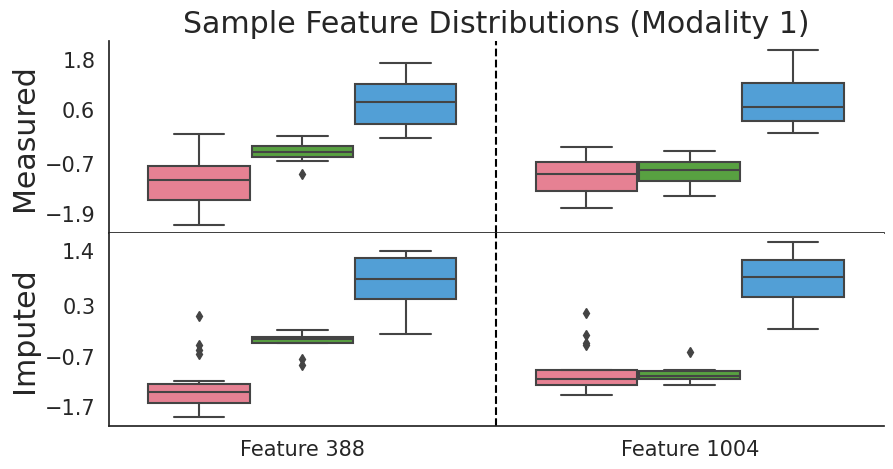

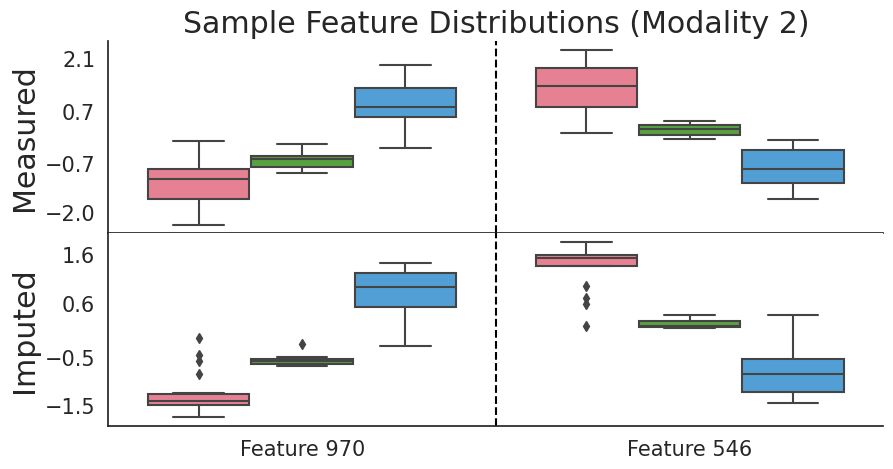

In [26]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist2.svg', format='svg', bbox_inches='tight')

Mean: 0.44962075511381816
Std: 0.10548912867774904
Mean: 0.46915952509820713
Std: 0.10570549512092361


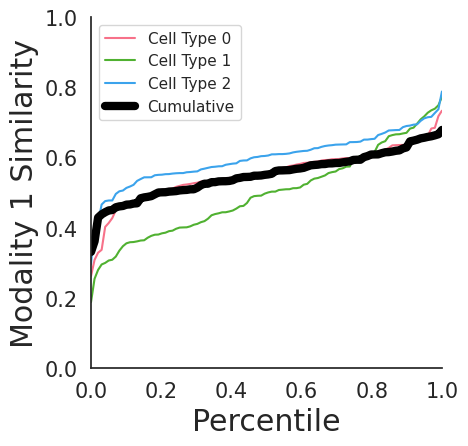

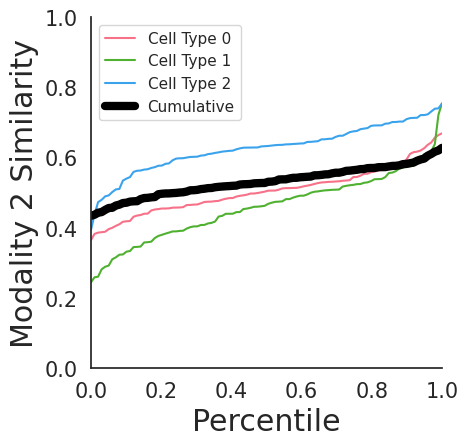

In [27]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Sim1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Sim2.svg', format='svg', bbox_inches='tight')